In [531]:
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt


In [532]:
### Generate n = 1000 samples of i.i.d N(0,1 ) gaussian random vectors and Rw = I2 

mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
# Diagonal covariance means that points are oriented along x or y-axis:
W = np.random.multivariate_normal(mean, cov, 1000)
W = W.T
#print(W.shape)

### Generate scaled random vaectors X~ = lambda_^(1/2) @ Wi

Rx = np.array([[2, -1.2], [-1.2, 1]])
evals, evects = np.linalg.eig(Rx)
# print(evals)
#print(evects)
evals = np.sqrt(evals) #apply square root to diagonal matrix of eigenvalues
lambda_ = np.diag(evals) #since eigenvalues are just returned as a column vector, we need to place it in a diag 
#matrix to do computation. 
#print("lambda_", lambda_)
Xi_tilda = lambda_ @ W
print(Xi_tilda.shape)
#print(Xi)


### Generate samples Xi by applying transformation Xi = EX~i

Xi = evects @ Xi_tilda

### Produce scatter plots of W, X~, and X in seperate figure windows. For each, use commands similar to plt.plot
#(W[0,:], W[1:], '.') assuming W is oriented as p x n

(2, 1000)


Text(0.5, 1.0, 'W')

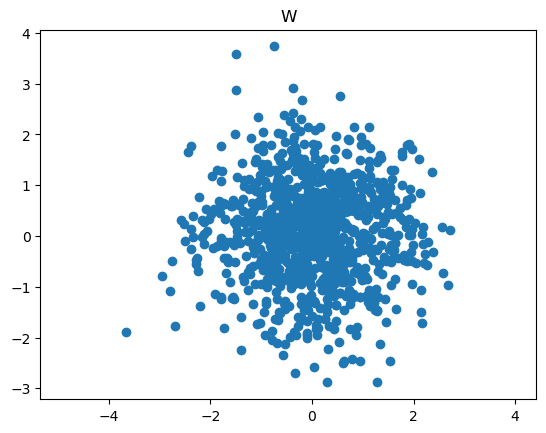

In [65]:
plt.scatter(W[0,:], W[1,:])
plt.axis("equal")
plt.title("W")

Text(0.5, 1.0, 'Xi tilda')

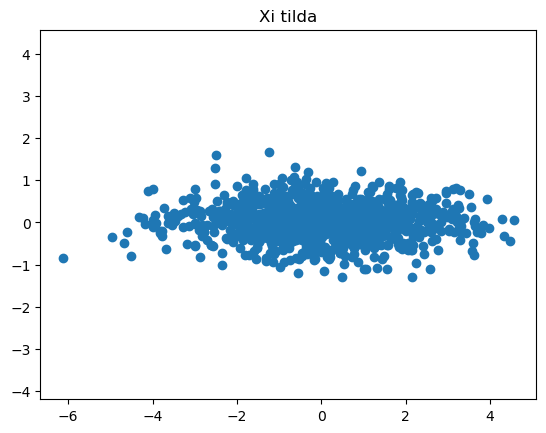

In [66]:
plt.scatter(Xi_tilda[0,], Xi_tilda[1,:])
plt.axis("equal")
plt.title("Xi tilda")

Text(0.5, 1.0, 'Xi')

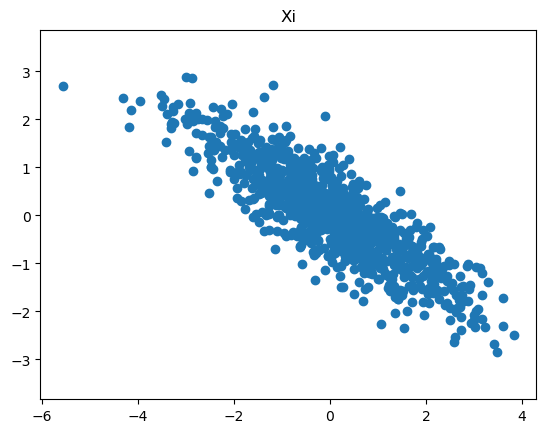

In [69]:
plt.scatter(Xi[0,:], Xi[1,:])
plt.axis('equal')
plt.title("Xi")

In [138]:
### Using 1000 samples of Xi generated in prev exercies, estimate the coveriance using expressions 17 and 18. 
### Produce a listing of the covariance estimate and compare to the theoretical values ####

# To generate covariance, R^, we first need to generate mu^ then using mu^, generate R^
n = 1000 #number of samples
mu_hat = np.mean(Xi, axis = 1) #compute mu^ by taking the average of 1,000 2d vectors

mu_hat = mu_hat.reshape((2,1)) #need to reshape mu_hat from (2, ) to (2, 1) in order to do the subtraction 
#operation (i.e, Xi - mu_hat)

Z = Xi - mu_hat #Z is the mean centered data vector. mu_hat is subtracted from every column of Xi

R_hat = 1/(n-1) * Z @ Z.T
print(R_hat)








        


[[ 1.96835072 -1.19970869]
 [-1.19970869  0.99821816]]


Text(0.5, 1.0, 'Xi_tilda using estimated covariance matrix')

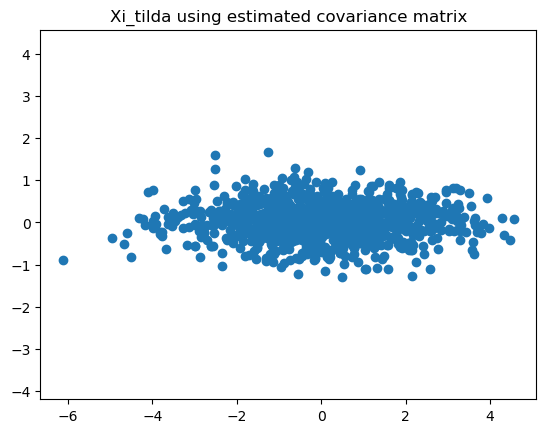

In [150]:
### Fron the covariance estimate, compute the transformation that will decorrelate the Xi samples as in eq
# 7 ( E[XX.T]) = lambda_, or, the eigenvalues on the diagonal of the matrix. Apply this transform to the data
# to produce the 0-mean decorrelated samples Xi. Basically, we need to use W = lambda_^-(1/2) @ E.T @ X
evals_R_hat, evects_R_hat = np.linalg.eig(R_hat)


zero_mean_decorrelated_samples = evects_R_hat.T @ Xi

#### Compute transfomration that will fully whiten Xi samples. Apply this transformation to the data 
# to produce 0-mean, identiy covariance samples Wi

lambda_R_hat = np.diag(evals_R_hat) # put eigenvalues into diagonal matrix

#the next two lines generate lambda to the power of minus 1/2 in two steps. 1) take inverse, 
# 2) compute square root. 
lambda_R_hat_inv = np.linalg.inv(lambda_R_hat)
lambda_minus_half = np.sqrt(lambda_R_hat_inv) #lambda_minus_half is lambda^(-1/2)

#Now, we need to apply this lambda_minus_half to E.T @ Xi
Wi = lambda_minus_half @ zero_mean_decorrelated_samples

### Produce scatter plots of Xi_tilda and Wi.
plt.scatter(zero_mean_decorrelated_samples[0,:], zero_mean_decorrelated_samples[1,:])
plt.axis("equal")
plt.title("Xi_tilda using estimated covariance matrix")




Text(0.5, 1.0, 'Wi ')

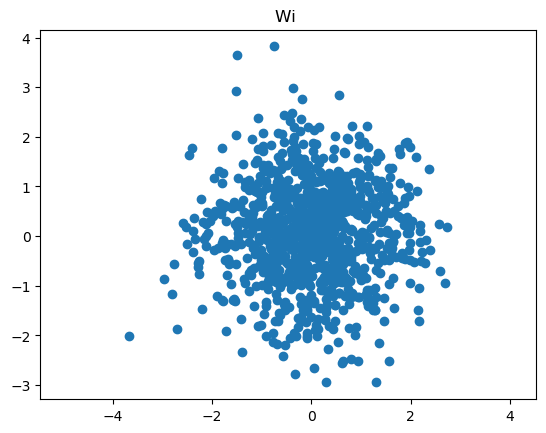

In [151]:
plt.scatter(Wi[0,:], Wi[1,:])
plt.axis("equal")
plt.title("Wi ")

In [160]:
### Produce covariance estimate of R^w. 
## find mean of W, then, use mean to compute covariance via Z = (Wi - mu), R^w = Z@Z.T

mu_Rw = np.mean(Wi, axis = 1)
print(mu_Rw.shape)

mu_Rw = mu_Rw.reshape(2,1)

Z = Wi - mu_Rw

Rw_hat = 1/(n-1) * Z @ Z.T

print(Rw_hat)



(2,)
[[1.00000000e+00 5.72458747e-16]
 [5.65519853e-16 1.00000000e+00]]
/Users/alim/Documents/ECE637/hw5


(4096, 312)


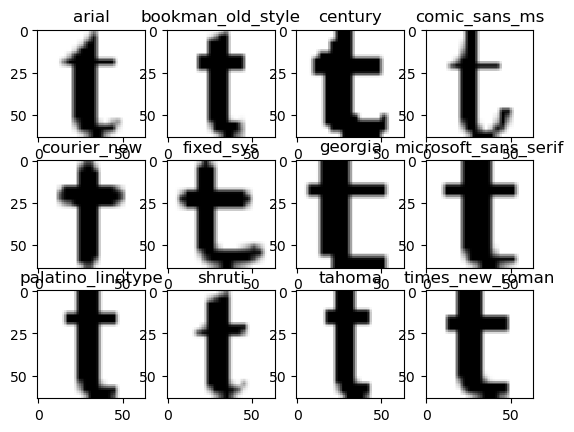

In [164]:
### Part 3 - Estimation of Eigenvectors and Eignevalues using SVD ###
### import function from read_data.py to read images into vector X ###
### This is copying the read_data.py script given in the HW to store a pxn matrix (4096 x 312) of images.
### there are 4,096 pixels (i.e each image = 64x64) in each image and 312 images in the dataset ###

direc = '/Users/alim/Documents/ECE637/hw5/training_data/'
os.chdir(direc)
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 15 19:32:39 2021
ECE637
Prof. Charles A. Bouman
Image Processing Laboratory: Eigenimages and Principal Component Analysis

Description:

This is a Matlab script that reads in a set of training images into
the Matlab workspace.  The images are sets of English letters written
in various fonts.  Each image is reshaped and placed into a column
of a data matrix, "X".
@author: Wenrui Li
"""

import numpy as np
from PIL import Image    
import matplotlib.pyplot as plt

# The following are strings used to assemble the data file names
datadir='.'    # directory where the data files reside
dataset=['arial','bookman_old_style','century','comic_sans_ms','courier_new',
  'fixed_sys','georgia','microsoft_sans_serif','palatino_linotype',
  'shruti','tahoma','times_new_roman']
datachar='abcdefghijklmnopqrstuvwxyz'

def read_data():
    """
        Read in all these training images into columns of a single matrix X.
    
        Returns:
            X: Image column matrix.
    
    """
    Rows=64    # all images are 64x64
    Cols=64
    n=len(dataset)*len(datachar)  # total number of images
    p=Rows*Cols   # number of pixels

    X=np.zeros((p,n))  # images arranged in columns of X
    k=0
    for dset in dataset:
        for ch in datachar:
            fname='/'.join([datadir,dset,ch])+'.tif'
            im=Image.open(fname)
            img = np.array(im)
            X[:,k]=np.reshape(img,(1,p))
            k+=1
    return X

# display samples of the training data
def display_samples(X,ch):
    """
    Display samples.

    Args:
    X (ndarray) : Image column matrix.
    ch (char) : A char 'a'~'z'.

    Returns:

    """
    ind = ord(ch)-ord('a')
    fig, axs = plt.subplots(3, 4)
    for k in range(len(dataset)):
        img=np.reshape(X[:,26*(k-1)+ind],(64,64))

        axs[k//4,k%4].imshow(img,cmap=plt.cm.gray, interpolation='none') 
        axs[k//4,k%4].set_title(dataset[k])


#if __name__ == "__main__":
X = read_data()
display_samples(X,'t')


In [525]:
### Compute the mean mu_hat over the entire dataset, then, center the data by subtracting the mean imag from each
### column of X

mu_img = np.mean(X, axis = 1) #get average image (i.e avg column vector of X)
mu_img = mu_img.reshape(4096,1) #reshape so we do np computations
mean_centered_X = X - mu_img


[[237.45192308]
 [237.45192308]
 [234.40705128]
 ...
 [249.22115385]
 [251.37820513]
 [251.37820513]]


In [261]:
### Compute the eigenvals and eigenvects of the image covariance. Do not compute co-variance matrix directly 
### (it is too large). Compute SVD

Z = 1/np.sqrt(312) * mean_centered_X
print(Z.shape)
U, S, V = np.linalg.svd(Z)
print(U.shape)
#The n columns of U are the eigenvectors of R, diagonal elements of S are the square roots of the eigenvalues

(4096, 312)
(4096, 4096)


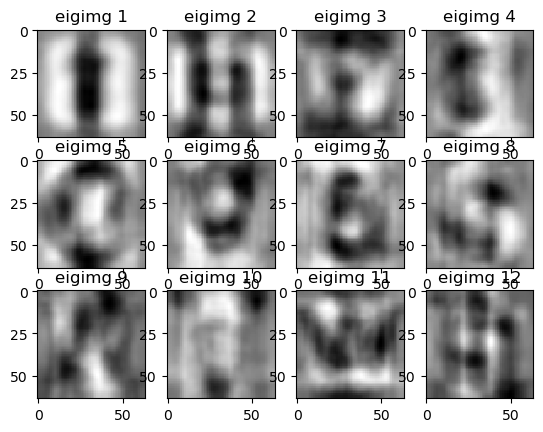

In [262]:
### get the 12 largest eigenvalues of S:
### Hand in figure with the first 12 eigenimages (i.e, eigenvectors)
## eigenvectors are stored in U

idx_maxes = np.argsort(S)
#print(idx_maxes)
### So, we can visually see that the largest eigenvalues are in in 0:11 of S
img = U[:,0].reshape(64,64)
fig, axs = plt.subplots(3, 4)
for k in range(12):
    img=np.reshape(U[:,k],(64,64))
    axs[k//4,k%4].imshow(img,cmap=plt.cm.gray, interpolation='none') 
    axs[k//4,k%4].set_title('eigimg ' + str(k+1))

[[1 2 3 4]
 [2 3 4 5]]
(312, 312)
[ 1  2  3  4  5  6  7  8  9 10]


Text(0, 0.5, 'projection coefficient')

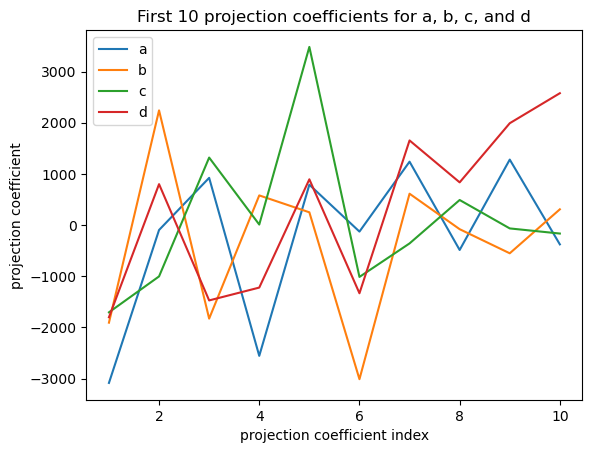

In [311]:
### For each image in the centered dataset (called mean_centered_X), compute the projection coeffients, 
# Y = U.T @ mean_centered_X along the n eigenvectors in U. Note that the proj co-eff Y for each image is a nx1 
# col vector, so they can be places as cols in a single matrix. 
one = np.array([1, 2, 3, 4])
two = np.array([2, 3, 4, 5])
three = np.vstack([one,two])
print(three)


for i in range(312):
    if i == 0:
        temp = U.T[0:312,:] @ mean_centered_X[:,i]
        a = temp
    else:
    
        temp = U.T[0:312,:] @ mean_centered_X[:,i]
        a = np.vstack([a, temp])
    Y = a.T #return Y with columns representing each proejction coefficient. Currently, the vstack func
    #stack each projection horizontally (not sure why...) 
 #note that the rows of U.T correspond to each eigenvector. So, we are multiplying the first 312
# eigenvectors of X@X.T by the mean centered value of each image to get a 312 x 312

print(Y.shape)

#Plot the first 10 projection co-efficients for the first 4 images. a, b, c, d are in X[:,:4]. For each of these 
# letters, plot the vals of the first 10 coefficients. 

#coefficients for a are in the first col of Y:
idx = np.arange(0,10) + 1
print(idx)
plt.plot(idx, Y[0:10, 0], label="a")
plt.plot(idx, Y[0:10, 1], label="b")
plt.plot(idx, Y[0:10, 2], label="c")
plt.plot(idx, Y[0:10, 3], label="d")
plt.legend()
plt.title("First 10 projection coefficients for a, b, c, and d")
plt.xlabel("projection coefficient index")
plt.ylabel("projection coefficient")



Y.shape (1,)
U[0:i, :].shape (1, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)
Y.shape (5,)
U[0:i, :].shape (5, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)
Y.shape (10,)
U[0:i, :].shape (10, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)
Y.shape (15,)
U[0:i, :].shape (15, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)
Y.shape (20,)
U[0:i, :].shape (20, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)
Y.shape (30,)
U[0:i, :].shape (30, 4096)
X_hat.shape (4096, 1)
mu_img.shape (4096, 1)
X_hat.shape (4096, 1)


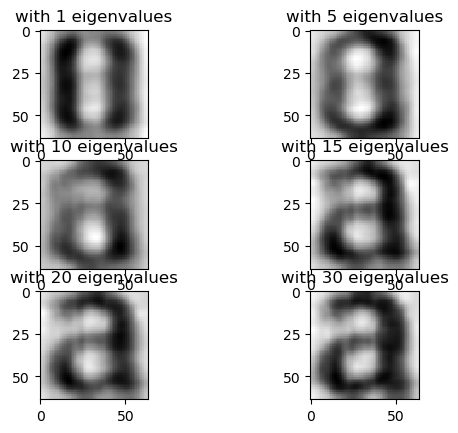

In [345]:
#Show result of syntehsizing the original image using the first m eigenvectors, where m = 1, 5, 10, 15, 20, 30

m = [1, 5, 10, 15, 20, 30]
fig, axs = plt.subplots(3,2)

#synthesize image using m eigenvectors:
for n, i in enumerate(m):
    #compute Y = Um.T @ X, where Um are the m eigenvectors in U
    Y = U.T[0:i, :] @ mean_centered_X[:,0]
    print("Y.shape", Y.shape)
    print("U[0:i, :].shape", U[0:i, :].shape)
    X_hat = U[:, 0:i] @ Y
    X_hat = X_hat.reshape(4096,1)
    print("X_hat.shape", X_hat.shape)
    print("mu_img.shape", mu_img.shape)
    X_hat = X_hat + mu_img
    print("X_hat.shape", X_hat.shape)
    
    img=np.reshape(X_hat,(64,64))
    axs[n//2,n%2].imshow(img,cmap=plt.cm.gray, interpolation='none') 
    axs[n//2,n%2].set_title("with " + str(m[n]) + " eigenvalues")
    

Text(0.5, 1.0, 'original image')

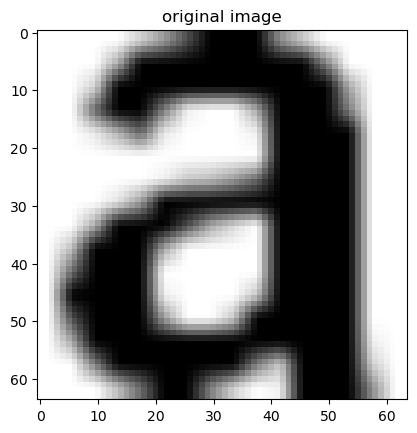

In [324]:
#plot original image in X[:,0]
img = X[:,0].reshape(64,64)
plt.imshow(img, cmap=plt.cm.gray, interpolation='none')
plt.title("original image")

In [530]:
#### Exercise 5.1: Classification and PCA ####

## first, we need to reduce the dimension of the training data using PCA ###
#1. Copmute eigenvectors for the covariance of the combined data set. This is already done. The eigenvectors 
# are stored in the variable U above. We are not going to think about class for now, so, we can use the mu_hat from
# earlier. 

#2. Form the transformation matrix A using the first 10 eigenvectors (corresponding to the 10 largest eigenvalues)

A = U[:,0:10]

#3. Transform each of the orig training images in X to a lower representation by first subtracting the global img
#mean mu^ from the image then applying the transformation A, so, basically, Y = A.T(X - mu^)
# we have already computed X - mu_img as mean_centered_X earlier!
Y = A.T @ mean_centered_X
print("Y", Y)
print("mean_centered_X", mean_centered_X)
#4. Using the data vectors Yi, compute the class means and cov for each of the 26 classes
#mu_k = 1/ |Ck| * sum from i to |Ck| of Yi^k 
Ck = 12 #there are 12 training vectors of each class
print(Y.shape)

#linspace(start, stop, num=50, endpoint=True,
idx = np.linspace(0,312, num = 12, endpoint=False)

count = 0
params_mu_hat = {}
params_r_hat = {}
# if we get every 26th "img" in Y, then, we can 
for i in range(26): 
    mu_hat = 0
    for j in range(12): #get low dim representation of the current letter i in range 0, 26. It is stored
        #in every 26th column of Y
        
        #print(Y[:,i + 26*j]) #when iterating through range of j, we will traverse through each representation
        # of the letter corresponding to i. For example, if i = 0, that is the letter a. If i =25, that is
        #the letter z.
        mu_hat = mu_hat + Y[:, i + 26*j]
        if j == 11:
            mu_hat = mu_hat / Ck
            params_mu_hat[i] = mu_hat.reshape(10,1)


for i in range(26):
    R_hat = 0
    for j in range(12): #get low dim representation of current letter i in range 0, 26. It is stored in 
        # every 26th column of Y. To access every 26th column, we can use i + 26 * j
        
        Yi = Y[:,i+26*j] 
        
        Yi = Yi.reshape(10,1)
        mu_hat = params_mu_hat[i]
        
#         print(Yi.shape)
#         print(Yi.T.shape)
        
        #print(Y[:,i + 26 * j].T.shape)
        R_hat = R_hat + ((Yi - mu_hat) @ (Yi - mu_hat).T)
        #print(R_hat.shape)
        if j == 11:
            R_hat = R_hat * (1/(Ck-1))
            params_r_hat[i] = R_hat

            
print("params_mu_hat[0]", params_mu_hat[0])
print("Params_r_hat[0]", params_r_hat[0])
### We now have computed the mean and covariance matrices for all 26 classes of the training data.

# Now, use the test data to test the classifier. Classifier is:
#k* = class label = argmin(k) {(y - mu_k).T@ inv(Rk) + log(|Rk|)}

# You first need to reduce the dimension of each input image using the same transformation Y = A.T @ (X - mu)
# We need to project on the same subspace used for training data, so, we need to use the same A and mu^ we 
# computed earlier in this process. Only X will be different (i.e, it is the test data instead of training data).

### READ TEST DATA ###
direc = '/Users/alim/Documents/ECE637/hw5/test_data/'
os.chdir(direc)
dataset=['veranda']

X_test = read_data()


### DONE READING TEST DATA FROM DISK - IT IS STORED IN X_test ####

## apply transformation Y = A.T @ (X-mu)
Y_test = A.T @ (X_test - mu_img)
print("Y_test", Y_test)
print("A.T", A.T)
print("X_test", X_test)

# use each image in Y_test to generate a classification.

comps = np.zeros(26)
comps = comps.reshape(26,1)

import string
alpha_dict = dict(enumerate(string.ascii_lowercase))

k = []
print(Y_test.shape)
for i in range(Y_test.shape[1]): #test each letter 
    for j in range(0,26):
        #compute the (y-mu_k).T @ Rk^-1 @ (y-mu_k) + log|Rk|, then add it to list.
        #when range is complete, find the minimum argument, return the index
        
        y = Y_test[:,i].reshape(10,1)
        #print(y.shape, params_mu_hat[j].shape)
        y_centered = y - params_mu_hat[j]
        #print("y_centered.shape", y_centered.shape)
        y_centered = y_centered.reshape(10,1)
        r_hat_inv = np.linalg.inv(params_r_hat[j])
        det_r_hat = np.linalg.det(params_r_hat[j])
        #print(det_r_hat)
        comps[j,0] = (y_centered.T @ r_hat_inv @ y_centered) + np.log(det_r_hat)
        if j == 25:
            #print(comps)
            letter = np.argmin(comps, axis = 0)
            k.append(int(letter))

for n, i in enumerate(k):
    #print("Label:" + alpha_dict[n] + "    Predicted:" + alpha_dict[i])
    if n<1:
        print("Misclassifications:")
        print("Inputs:   Outputs:")
    if alpha_dict[n] != alpha_dict[i]:
        print(alpha_dict[n] + "             " + alpha_dict[i])
            
  
         
# def compute_argmin_k(data, y_centered_matrix, Bk):
#     for i in range(0, data.shape[1]):
#         for j in range(0,)
    

Y [[-3084.5041568  -1907.39654325 -1705.15078105 ...  1825.46189504
   3917.12032195  1997.07965962]
 [  -96.61139317  2240.51216154 -1003.45167378 ...   925.35100988
     48.20868773   670.80072402]
 [  922.2022264  -1828.0636984   1318.38724218 ...   636.95420703
    343.09964675  3156.44812497]
 ...
 [ -487.04905028   -80.67833037   489.65855171 ... -1678.84966465
  -1160.88979682  1365.71220692]
 [ 1279.10757933  -551.70148633   -65.8426798  ...   217.26329148
   1128.2844095    512.19042099]
 [ -377.54227456   307.48854809  -165.9069466  ...  -286.9082926
   -176.93356426   579.95486105]]
mean_centered_X [[ 17.54807692  17.54807692  17.54807692 ... -12.45192308  17.54807692
   17.54807692]
 [ 17.54807692  17.54807692  17.54807692 ... -12.45192308  17.54807692
   17.54807692]
 [ 20.59294872  20.59294872  20.59294872 ... -20.40705128  20.59294872
   20.59294872]
 ...
 [ -8.22115385   5.77884615   5.77884615 ...   5.77884615   5.77884615
    3.77884615]
 [  3.62179487   3.62179487   

In [529]:
### Part 5.2 - Constrain Rk to reduce classification error ###


### Create lambda_k, where lambda_k are the diagonal elements of Rk
lambda_k = {}
lambda_k_mat = np.zeros((10,10))
for n, i in enumerate(range(len(params_r_hat))):
    #print(params_r_hat[n].shape)
    diag_r_k = np.diag(params_r_hat[n])
    lambda_k[n] = np.diag(diag_r_k)
    
    
    


### Create Rwc, where Rwc is the average matrix of all the r_hat matrices
total = 0
Rwc = np.zeros((10,10))
for n, i in enumerate(range(len(params_r_hat))):
    total =  total + params_r_hat[n]
    if n == len(params_r_hat) - 1:
        Rwc = total / 26

print(Rwc.shape)
        
    


### Create lambda_, where the elements of lambda_ are the diagonal elements of Rwc
lambda_ = np.diag(Rwc)

lambda_ = np.diag(lambda_) #convert to a 2d representation of a diagonal for easy matrix computations. 
print(lambda_.shape)


### Let the constrained matrix Bk = I
Bk = np.eye((10))
print(Bk.shape)

def compute_argmin_k(test_data, Bk, scenario):
    k = []
    comps = np.zeros(26)
    comps = comps.reshape(26,1)
    for i in range(test_data.shape[1]):
        if (isinstance(Bk, dict)):
            for j in range(0,26):
                y = test_data[:,i].reshape(10,1)
                y_centered = y - params_mu_hat[j]
                y_centered = y_centered.reshape(10,1)
                Bk_inv = np.linalg.inv(Bk[j])
                det_Bk = np.linalg.det(Bk[j])
                comps[j,0] = (y_centered.T @ Bk_inv @ y_centered) + np.log(det_Bk)
        else:
            for j in range(0,26):
                y = test_data[:,i].reshape(10,1)
                y_centered = y - params_mu_hat[j]
                y_centered = y_centered.reshape(10,1)
                Bk_inv = np.linalg.inv(Bk)
                det_Bk = np.linalg.det(Bk)
                comps[j,0] = (y_centered.T @ Bk_inv @ y_centered) + np.log(det_Bk)
        if j == 25:

            letter = np.argmin(comps, axis = 0)
            k.append(int(letter))
    
    for n, i in enumerate(k):
    #print("Label:" + alpha_dict[n] + "    Predicted:" + alpha_dict[i])
        if n<1:
            print("Misclassifications for " + scenario + ":")
            print("Inputs:   Outputs:")
        if alpha_dict[n] != alpha_dict[i]:
            print(alpha_dict[n] + "             " + alpha_dict[i])



compute_argmin_k(Y_test, lambda_k, scenario = "Bk = lambda_k")
compute_argmin_k(Y_test, Rwc, scenario = "Bk = Rwc")
compute_argmin_k(Y_test, lambda_, scenario = "Bk = lambda" )
compute_argmin_k(Y_test, Bk, scenario = "Bk = I" )


            
        


(10, 10)
(10, 10)
(10, 10)
Misclassifications for Bk = lambda_k:
Inputs:   Outputs:
i             l
y             v
Misclassifications for Bk = Rwc:
Inputs:   Outputs:
g             q
y             v
Misclassifications for Bk = lambda:
Inputs:   Outputs:
f             t
y             v
Misclassifications for Bk = I:
Inputs:   Outputs:
f             t
g             q
y             v
